In [49]:
scores = '../out/ko_scores.txt'
dev = '../out/deviating.tsv'
sgd = '../out/SGD_features.tab'

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

sns.set_style('white')

plt.rc('font', size=11)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=11)

In [3]:
import numpy as np
import pandas as pd

In [63]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

In [6]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
    print(s, len(gs))
print('')
print('total', len(genes))
genes = sorted(genes)
p = m.reset_index().set_index('gene').loc[genes].groupby('condition').sum()['phenotype']

UWOP 4014
Y55 4190
S288C 4889
YPS 4093

total 3786


In [7]:
d = pd.read_table(dev, index_col=[4, 5, 1, 0])

In [8]:
res = []
for s1, s2 in {tuple(x[:2])
               for x in d.index}:
    v1 = m.loc[s1].loc[genes]
    v1 = v1[~v1.index.duplicated()].dropna()
    idx1 = set(v1[v1['phenotype']].index)
    v2 = m.loc[s2].loc[genes]
    v2 = v2[~v2.index.duplicated()].dropna()
    idx2 = set(v2[v2['phenotype']].index)
    idx = idx1.union(idx2)
    v = d.loc[(s1, s2), ].loc[sorted(idx)].dropna()
    vs1 = set(v[v['qval'] < 0.01].loc[sorted(idx1)].dropna().index.difference(v[v['qval'] < 0.01].loc[sorted(idx2)].dropna().index))
    vs2 = set(v[v['qval'] < 0.01].loc[sorted(idx2)].dropna().index.difference(v[v['qval'] < 0.01].loc[sorted(idx1)].dropna().index))
    vs3 = set(v[v['qval'] < 0.01].loc[sorted(idx2)].dropna().index.intersection(v[v['qval'] < 0.01].loc[sorted(idx1)].dropna().index))
    vs = idx - vs1 - vs2 - vs3
    res.append(([len(vs1), len(vs), len(vs2), len(vs3)], [s1, s2]))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1367: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [9]:
strains = {y
           for x in d.index
           for y in x[:2]}
palette = sns.color_palette('Set1', len(strains))
cstrains = {x: c
            for x,c in zip(strains, palette)}

/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


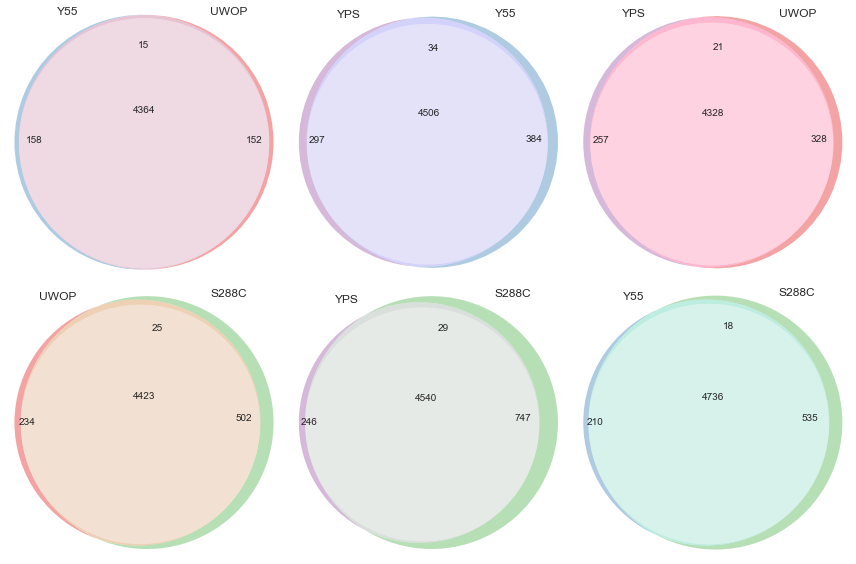

In [10]:
plt.figure(figsize=(12, 8))

for i, t in enumerate(res):
    plt.subplot(2, 3, i+1)
    
    (vs1, vs, vs2, vs3), (s1, s2) = t
    
    _ = venn3([vs1, vs2, vs3,
               0, 0, 0, vs],
              [s1, s2, ''],
              normalize_to=10,
              set_colors=[cstrains[s1],
                          cstrains[s2],
                          'w'])
plt.tight_layout()

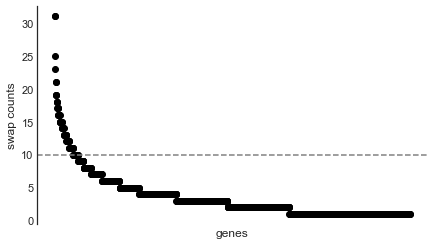

In [56]:
v = d.reset_index().set_index('gene').loc[genes]
v = v[v['qval'] < 0.01].groupby('gene').count()['qval'].sort_values(ascending=False)
idx = v.index

plt.figure(figsize=(7, 4))

plt.plot(range(v.shape[0]),
         v,
         'ko')

plt.axhline(10,
            linestyle='dashed',
            color='grey')

plt.xticks([])
plt.ylabel('swap counts')
plt.xlabel('genes')
sns.despine(bottom=True);

In [67]:
vg = v.copy().to_frame()
vg['name'] = [gn.get(x, '')
              for x in vg.index]
vg['description'] = [gd.get(x, '')
                     for x in vg.index]
vg.columns = ['swaps', 'name', 'description']
vg.head(10)

,swaps,name,description
gene,,,
YBR101C,31,FES1,Hsp70 (Ssa1p) nucleotide exchange factor; requ...
YBR036C,31,CSG2,Endoplasmic reticulum membrane protein; requir...
YNR029C,25,,Putative protein of unknown function; deletion...
YML121W,23,GTR1,Subunit of a TORC1-stimulating GTPase complex;...
YDR126W,21,SWF1,Palmitoyltransferase that acts on transmembran...
YOR358W,21,HAP5,Subunit of the Hap2p/3p/4p/5p CCAAT-binding co...
YCR009C,19,RVS161,Amphiphysin-like lipid raft protein; N-BAR dom...
YGR135W,19,PRE9,Alpha 3 subunit of the 20S proteasome; the onl...
YBR171W,19,SEC66,Non-essential subunit of Sec63 complex; with S...


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1367: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


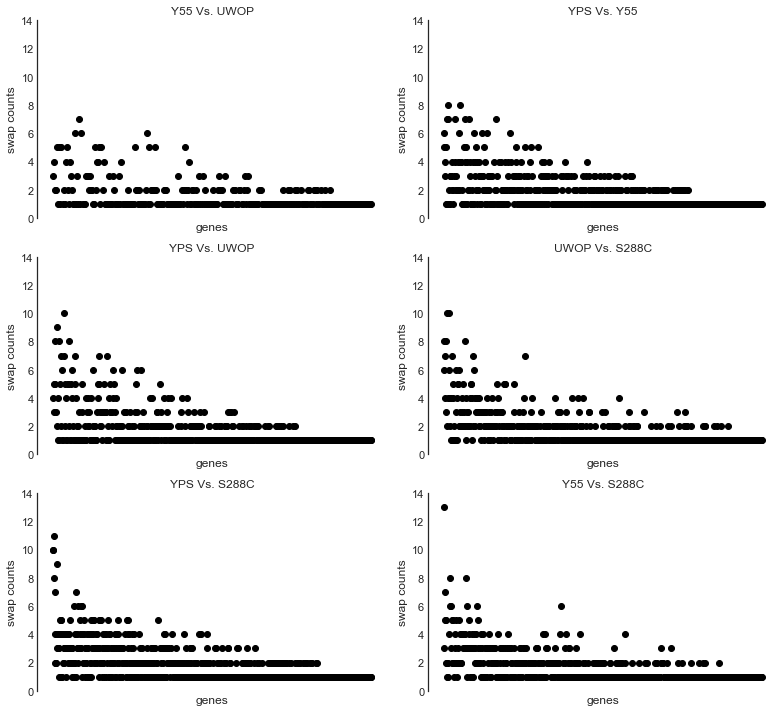

In [34]:
plt.figure(figsize=(11, 10))

i = 1
for s1, s2 in {tuple(x[:2])
               for x in d.index}:
    plt.subplot(3, 2, i)
    
    v = d.loc[(s1, s2), ].reset_index().set_index('gene').loc[genes]
    v = v[v['qval'] < 0.01].groupby('gene').count()['qval']
    v = v.reindex(idx).dropna()
    
    plt.plot(range(v.shape[0]),
         v,
         'ko')

    plt.ylim(0, 14)
    
    plt.xticks([])
    plt.ylabel('swap counts')
    plt.xlabel('genes')
    plt.title('%s Vs. %s' % (s1, s2))
    
    i += 1

plt.tight_layout()
sns.despine(bottom=True)

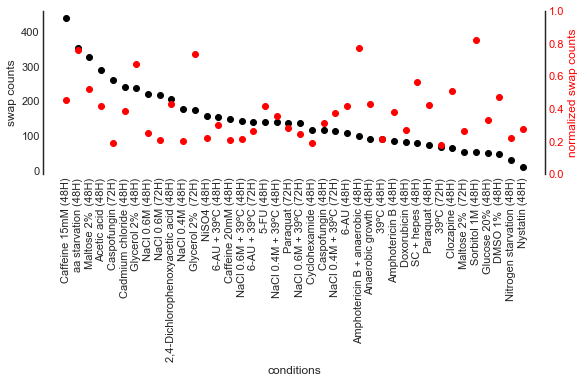

In [40]:
v = d.reset_index().set_index('gene').loc[genes]
v = v[v['qval'] < 0.01].groupby('condition').count()['qval'].sort_values(ascending=False)
idx = v.index

plt.figure(figsize=(9, 3))

plt.plot(range(v.shape[0]),
         v,
         'ko')

plt.xticks(range(v.shape[0]),
           v.index,
           rotation=90)
plt.ylabel('swap counts')
plt.xlabel('conditions')

plt.twinx()
plt.plot(range(v.shape[0]),
         v / p.loc[idx],
         'ro')

plt.tick_params('y', colors='r')
plt.ylabel('normalized swap counts',
           color='r')
plt.ylim(0, 1)

sns.despine(right=False,
            bottom=True);

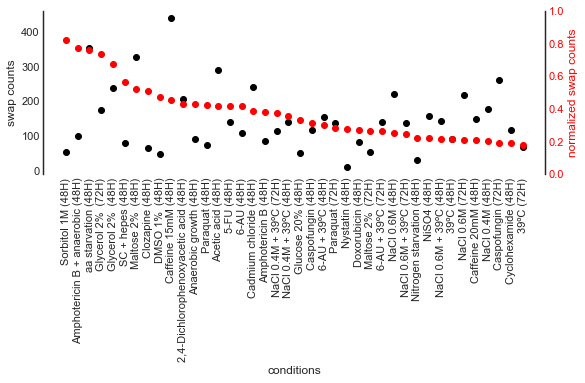

In [45]:
v = d.reset_index().set_index('gene').loc[genes]
v = v[v['qval'] < 0.01].groupby('condition').count()['qval'].sort_values(ascending=False)
idx = v.index
v1 = v / p.loc[idx]
v1 = v1.sort_values(ascending=False)
idx = v1.index
v = v.loc[idx]


plt.figure(figsize=(9, 3))

plt.plot(range(v.shape[0]),
         v,
         'ko')

plt.xticks(range(v.shape[0]),
           v.index,
           rotation=90)
plt.ylabel('swap counts')
plt.xlabel('conditions')

plt.twinx()
plt.plot(range(v.shape[0]),
         v / p.loc[idx],
         'ro')

plt.tick_params('y', colors='r')
plt.ylabel('normalized swap counts',
           color='r')
plt.ylim(0, 1)

sns.despine(right=False,
            bottom=True);

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1367: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


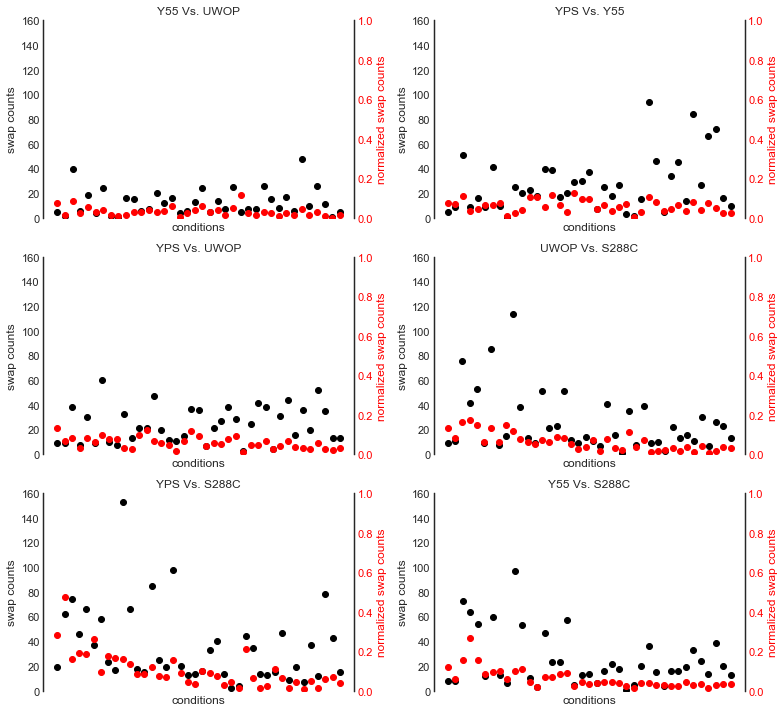

In [46]:
plt.figure(figsize=(11, 10))

i = 1
for s1, s2 in {tuple(x[:2])
               for x in d.index}:
    plt.subplot(3, 2, i)
    
    v = d.loc[(s1, s2), ].reset_index().set_index('gene').loc[genes]
    v = v[v['qval'] < 0.01].groupby('condition').count()['qval']
    v = v.reindex(idx).dropna()
    
    plt.plot(range(v.shape[0]),
         v,
         'ko')

    plt.ylim(0, 160)
    
    plt.xticks([])
    plt.ylabel('swap counts')
    plt.xlabel('conditions')
    
    plt.twinx()
    plt.plot(range(v.shape[0]),
             v / p.loc[v.index],
             'ro')

    plt.tick_params('y', colors='r')
    plt.ylabel('normalized swap counts',
               color='r')
    plt.ylim(0, 1)
    
    plt.title('%s Vs. %s' % (s1, s2))
    
    i += 1

plt.tight_layout()
sns.despine(right=False,
            bottom=True);